# Quality Of Service
##  Data Analysis on Incidents

An incident is an event that could lead to loss of, or disruption to, an organization's operations, services, or functions. An Incident is defined as an unplanned interruption or reduction in quality of an IT service (a Service Interruption). 

Here, Incident’s information is captured for multiple customers for the last few months by the Company. Customers have different locations/sites and have circuits associated with those sites. These circuits are also related to products. There are critical timestamps capturing life cycle milestones. Issue reason and closure reason capture additional information on the incidents.  

There are four datasets which provides specific information about incidents, customers, service-target and measured-reason. The datasets I used are described below.

*   **1. Fact_Sheet:-** This dataset contains information about the incidents such as inc_id, inc_creation_date , inc_resoultion_date, customer_name etc. 



*   **2. Customer_Sheet:-** This dataset contains information about the customers such as customer_name, customer_id , inc_site etc.



*   **3. Measurable_Reason_Sheet:-** This dataset consists of the information regarding incident's closure reason and the measured flag.



*   **4. Severity_Target:-** This dataset provides information about severity ranging from 1 to 5 [1 being low, 5 being critical] and the company's resolution time target.









I aimed to solve following tasks by analysing the data and performing Data Preprocessing and Feature Engineering on the data.

**Task_1 - Key Volume of incidents** based on Customer, Site, Products, Issue Reason - Monthly

**Task_2 - Mean Time to Resolve (MTTR)** - Mean time taken from the creation of the incident (measured) to resolution based on Customer, Site, Products, Issue Reason - Monthly

**Task_3 - Mean Time to Resolve % (MTTR %)** - Number of incidents (measured) resolved within the target based on Customer, Site, Products, Issue Reason - Monthly 


**Task_4 - Service Availability %**
The percentage of time service was available at a customer site. 

* Down Time = Total time a service was unavailable at a customer site due to 
severity 1 or 2 (measured) incident. 

* Total Planned Uptime = Total calendar days (hours) the service is set up to be available at the customer site 

* Service Availability Hours = Total Planned Uptime – Down Time 

Find Service Availability% based on Customer and Site - Monthly


**Task_5 - Any additional information we can get from data**





In [1]:
#Importing mandatory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
#Importing Fact_Sheet data.
fact_data = pd.read_excel("Fact_Sheet.xlsx")
fact_data

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,gbc,blooth Cmpny,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,NaN,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,NaN,Pie Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,cloud Nine superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,BC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,rbm,rosebud motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pie Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001


#### By just looking at the above data, we can see that there are many missing values in the dataset. In addition to this, the inc_cust_id and int_cust_name have many datapoints with wrong spellings. In order to find the correct ids and names we need to check the customer_sheet data.  

In [3]:
#Importing Customer_Sheet data.
customer_data = pd.read_excel("Customer_Sheet.xlsx")
customer_data.head(10)

,inc_cust_id,inc_cust_name,inc_circuit,inc_site
0,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-BS-001
1,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-CO-001
2,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-DC-001
3,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-MH-001
4,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-MH-002
5,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-DC-001
6,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-STR-001
7,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-STR-002
8,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DMP-CO-001
9,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DMP-CO-002


In [4]:
#Importing Target_Time data.
Target_data = pd.read_excel("Severity_Target_Sheet.xlsx")
Target_data.head(10)

,Severity,Target Time To Resolve
0,1,2
1,2,4
2,3,8
3,4,24
4,5,48


In [5]:
measurable_reason_data = pd.read_excel("Measurable_reason_Sheet.xlsx")
measurable_reason_data.head(10)

,inc_closure_reason,measure_flag
0,Interface Config Change,1
1,Dropped & Recovered,1
2,No Trouble Found,0
3,Ticket Cancelled,0
4,Host Config Change,1
5,Circuit Config Change,1
6,Switch Incident Closed,1
7,Server Incident Closed,1
8,Power Supply Back,1
9,Switch Config Change,1


In [6]:
fact_data[["inc_cust_id"]].describe()

,inc_cust_id
count,131
unique,22
top,DMP
freq,13


In [7]:
fact_data[["inc_cust_name"]].describe()

,inc_cust_name
count,149
unique,28
top,Bluth Company
freq,15


#### In Fact_sheet dataset, there are 22 and 28 unique values of customer_id and customer_name respectively. We need to verify this unique value by checking the customer_sheet dataset.

In [8]:
customer_data[["inc_cust_id"]].describe()

,inc_cust_id
count,27
unique,7
top,DMP
freq,6


In [9]:
customer_data[["inc_cust_name"]].describe()

,inc_cust_name
count,27
unique,7
top,"Dunder Mifflin Paper Company, Inc."
freq,6


#### By examining the customer_data, we found that there is a vast difference between the unique values of the same feature in different datasets. This indicated that the Fact_Sheet dataset has wrong values of features. You can see that we have one more common feature - "inc_site" in both datasets. So, I compared its unique values in both datasets.

In [10]:
fact_data[["inc_site"]].describe()

,inc_site
count,155
unique,26
top,PPI-SVC-001
freq,14


In [11]:
customer_data[["inc_site"]].describe()

,inc_site
count,27
unique,25
top,IBB-WFL-001
freq,2


#### By comparing unique values of "inc_site" in both datasets, I got to know that the difference is only 1 so I can use this feature to correct the values of customer_id and customer_name. 
#### Also, the "inc_site" includes the customer_id in its value.

#### E.g inc_site = "GBC-MH-002" depicts the customer_id "GBC".


In [12]:
for i in range(len(fact_data)):
    fact_data["inc_cust_id"][i] = fact_data["inc_site"][i][:3]
fact_data[["inc_cust_id"]].describe()
print(fact_data[["inc_cust_id"]]["inc_cust_id"].unique())
print(customer_data[["inc_cust_id"]]["inc_cust_id"].unique())


['GBC' 'IBB' 'TAR' 'PPI' 'C9S' 'DMP' 'RBM' 'IBC']
['GBC' 'C9S' 'DMP' 'IBB' 'PPI' 'RBM' 'TAR']


<ipython-input-12-c3eec2501cef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["inc_cust_id"][i] = fact_data["inc_site"][i][:3]


#### Now the customer_id column is almost ready, we just need to change one value and we can get that value by comparing unique values of customer_id from both datasets.

In [13]:
for i in range(len(fact_data)):
    if fact_data["inc_cust_id"][i] == "IBC":
        fact_data["inc_cust_id"][i] = "IBB"
    if fact_data["inc_site"][i][:3] == "IBC":
        fact_data["inc_site"][i] = "IBB" + fact_data["inc_site"][i][3:]
print(fact_data[["inc_cust_id"]]["inc_cust_id"].unique())
print()


['GBC' 'IBB' 'TAR' 'PPI' 'C9S' 'DMP' 'RBM']



<ipython-input-13-2d0129e89aed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["inc_cust_id"][i] = "IBB"
<ipython-input-13-2d0129e89aed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["inc_site"][i] = "IBB" + fact_data["inc_site"][i][3:]


In [14]:
fact_data[["inc_site"]].describe()

,inc_site
count,155
unique,25
top,PPI-SVC-001
freq,14


#### We need to correct the customer_name column too. I used dictonary to save the customer_id and customer_name from customer dataset and used that same dictonary to correct fact_data.

In [15]:
dict = {}
for i in range(len(customer_data)):
    if customer_data["inc_cust_id"][i] not in dict:
        dict[customer_data["inc_cust_id"][i]] = customer_data["inc_cust_name"][i]
dict

{'GBC': 'Bluth Company',
 'C9S': 'Cloud 9 Superstore',
 'DMP': 'Dunder Mifflin Paper Company, Inc.',
 'IBB': 'Iron Bank',
 'PPI': 'Pied Piper Inc',
 'RBM': 'Rose Bud Motel',
 'TAR': 'The Alibi Room'}

In [16]:
for i in range(len(fact_data)):
    if fact_data["inc_cust_id"][i] in dict:
        fact_data["inc_cust_name"][i] = dict[fact_data["inc_cust_id"][i]]
fact_data[["inc_cust_name"]].describe()

<ipython-input-16-031324f16eae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["inc_cust_name"][i] = dict[fact_data["inc_cust_id"][i]]


,inc_cust_name
count,155
unique,7
top,"Dunder Mifflin Paper Company, Inc."
freq,30


In [17]:
fact_data

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001


### The both columns are corrected and now I can start the first task.

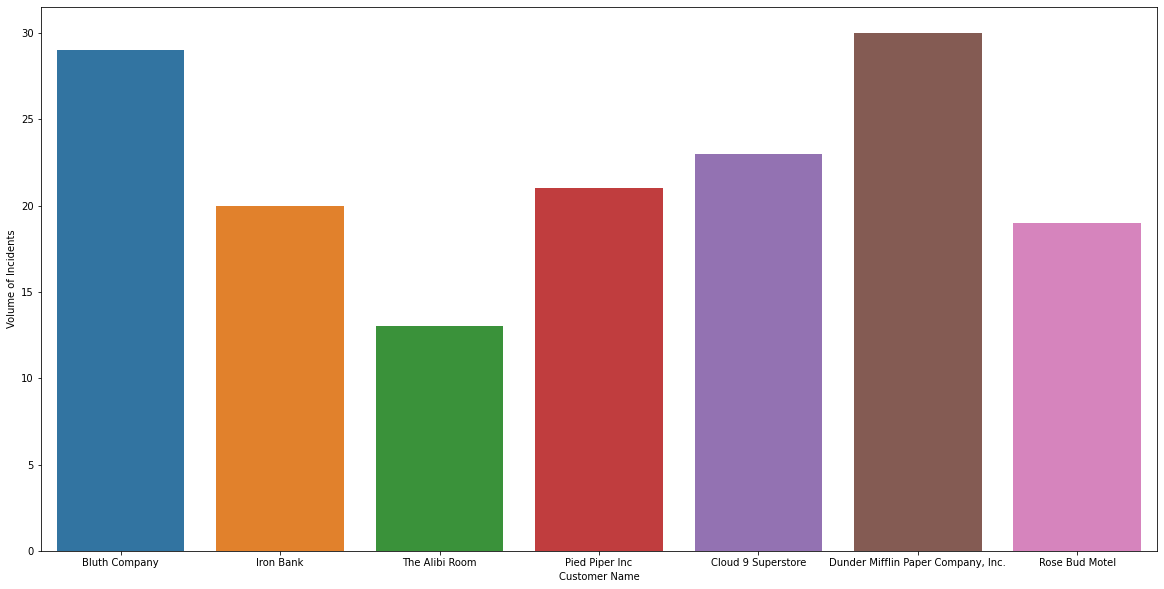

In [18]:
plt.figure(figsize=(20,10))
sns.countplot(fact_data["inc_cust_name"])
plt.ylabel("Volume of Incidents")
plt.xlabel("Customer Name")
plt.show()

By sutdying the above figure, we can see that Dunder Mifflin Paper Company, Inc.encountered highest number of incidents(30) over a period of 4 months whilst the The Alibi Room reported lowerst number of incidents(14) in a period of 4 months. Also Dunder Mifflin Paper Company has the highest sites and The Alibi Room has the lowest sites amongst all the customers. So we can say that there is a linear relationship between Number of incidents and number of sites.  

## Task_1 :- Key Volume of incidents
For the first task, I need to find the Volume of incidents based on Customer, Site, Products, Issue Reason - Monthly. So first, I created a new column "Month" containing the Month of the Incident.

In [19]:
fact_data["Month"] = "Nan"
for i in range(len(fact_data)):
    fact_data["Month"][i]= fact_data["inc_creation_dt"][i].month
fact_data.head(10)

<ipython-input-19-af85070784a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["Month"][i]= fact_data["inc_creation_dt"][i].month


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10
5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10
6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10
7,INC072176,Ticket Manager,1,CLOSED,2020-10-06 21:00:01,2020-10-06 22:10:06,2020-10-06 22:21:04,Switch Down,Switch Incident Closed,IBB,Iron Bank,CRCTIBB-0001CKT-AAB,Fiber Internet,IBB-WFL-001,10
8,INC072177,Ticket Manager,4,CLOSED,2020-10-08 08:26:09,2020-10-09 09:35:20,2020-10-09 09:38:29,Interface State Change,No Trouble Found,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-CO-003,10
9,INC072178,Ticket Manager,2,CLOSED,2020-10-08 08:32:59,2020-10-08 12:20:38,2020-10-08 12:22:38,Circuit Down,Circuit Config Change,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-001,10


             Iron Bank  Bluth Company  Dunder Mifflin Paper Company, Inc.  \
October-20           5              5                                   4   
November-20          6              8                                   9   
December-20          7              8                                   9   
January-20           2              8                                   8   

             Cloud 9 Superstore  Pied Piper Inc  Rose Bud Motel  \
October-20                    3               3               2   
November-20                   8               4               7   
December-20                   6              10               3   
January-20                    6               4               7   

             The Alibi Room  
October-20                2  
November-20               4  
December-20               4  
January-20                3  


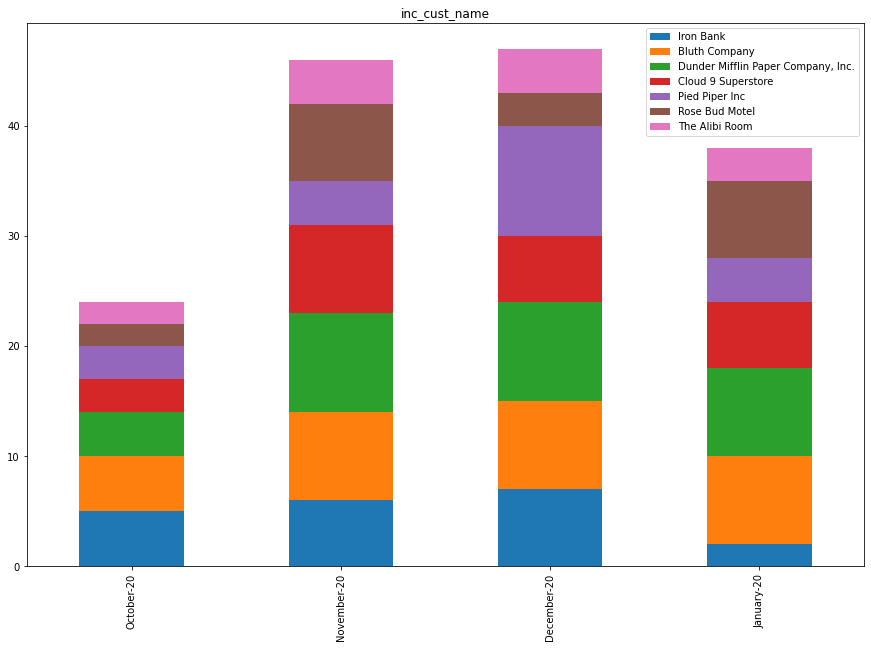

In [20]:
def bar_chart(feature):
    Oct_20 = fact_data[fact_data['Month']==10][feature].value_counts()
    Nov_20 = fact_data[fact_data['Month']==11][feature].value_counts()
    Dec_20 = fact_data[fact_data['Month']==12][feature].value_counts()
    Jan_21 = fact_data[fact_data['Month']==1][feature].value_counts()

    temp_df = pd.DataFrame([Oct_20,Nov_20,Dec_20,Jan_21])
    temp_df.index = ['October-20','November-20', 'December-20','January-20']
    temp_df.plot(kind='bar',stacked=True, figsize=(15,10))
    plt.title(feature)
    print(temp_df)

bar_chart('inc_cust_name')
#for i in fact_data[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
    #bar_chart(i)
    #print()


#### In the above figure, different colors represts different companies and the length of the bar of particular company represents number of incidents reported by the company.

#### Here, we can say that the average length of "The Alibi Room" company is lower than others and the average length of the "Dunder Mifflin Paper Company" is higher than others. 

             GBC-DC-001  DMP-CO-003  IBB-KLD-001  PPI-DC-001  IBB-WFL-001  \
October-20          2.0         2.0          2.0         2.0          2.0   
November-20         3.0         1.0          NaN         2.0          2.0   
December-20         2.0         3.0          4.0         2.0          2.0   
January-20          1.0         NaN          NaN         1.0          NaN   

             DMP-CO-004  IBB-BRV-001  TAR-SSC-002  C9S-STR-001  C9S-DC-001  \
October-20          2.0          1.0          1.0          1.0         1.0   
November-20         NaN          4.0          1.0          3.0         2.0   
December-20         3.0          1.0          NaN          2.0         2.0   
January-20          NaN          2.0          NaN          2.0         3.0   

             ...  GBC-MH-001  GBC-CO-001  TAR-SSC-001  RBM-SC-002  DMP-CO-001  \
October-20   ...         1.0         1.0          1.0         NaN         NaN   
November-20  ...         NaN         2.0          3.0        

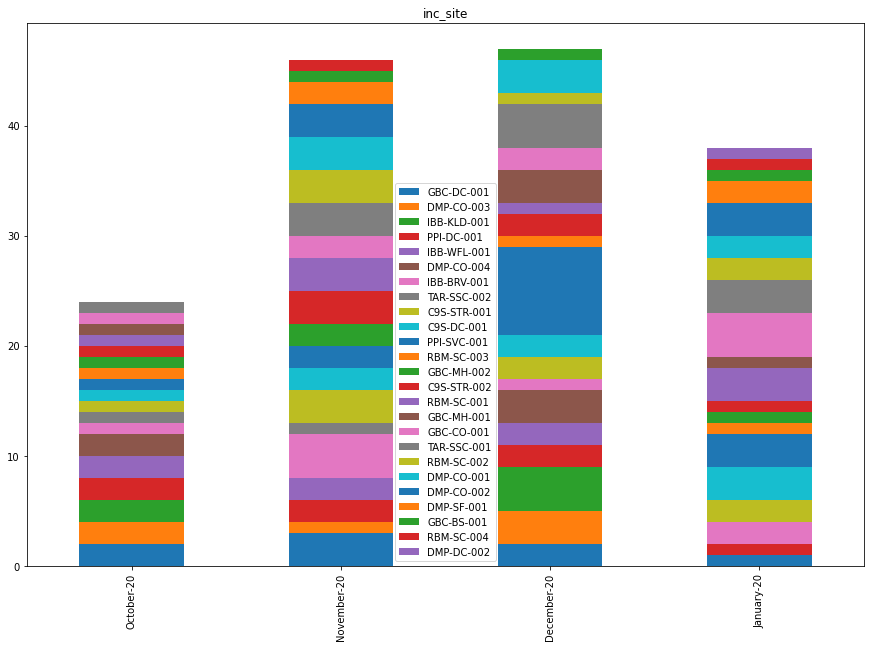

In [21]:
bar_chart('inc_site')

             Circuit Down  Cold Start  Power Supply Fail  \
October-20            3.0         3.0                3.0   
November-20           4.0         3.0                8.0   
December-20           5.0         6.0                8.0   
January-20            1.0         3.0                9.0   

             Circuit State Change  Switch State Change  Host Down  \
October-20                    3.0                  2.0        2.0   
November-20                   2.0                  6.0        4.0   
December-20                   6.0                  6.0        6.0   
January-20                    2.0                  4.0        3.0   

             Switch Down  Interface Down  Interface State Change  Server Down  \
October-20           2.0             2.0                     2.0          1.0   
November-20          4.0             4.0                     2.0          3.0   
December-20          3.0             2.0                     3.0          2.0   
January-20           5.0     

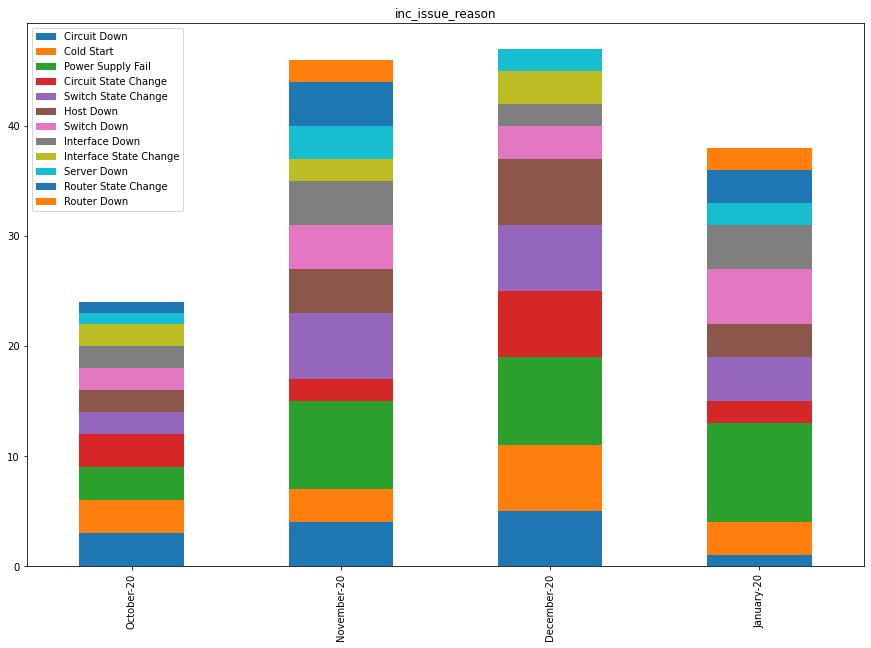

In [22]:
bar_chart('inc_issue_reason')

             DSL Internet  Fiber Internet  VOIP  VLAN   Physical Server  \
October-20            8.0             5.0   3.0    3.0              2.0   
November-20          15.0             8.0   3.0    2.0              7.0   
December-20          14.0            11.0   7.0    7.0              2.0   
January-20           11.0             6.0   2.0    1.0              5.0   

             Virtual Server  Data Center  VPN  PSTN  
October-20              2.0          1.0  NaN   NaN  
November-20             2.0          NaN  5.0   4.0  
December-20             2.0          2.0  NaN   2.0  
January-20              1.0          1.0  6.0   5.0  


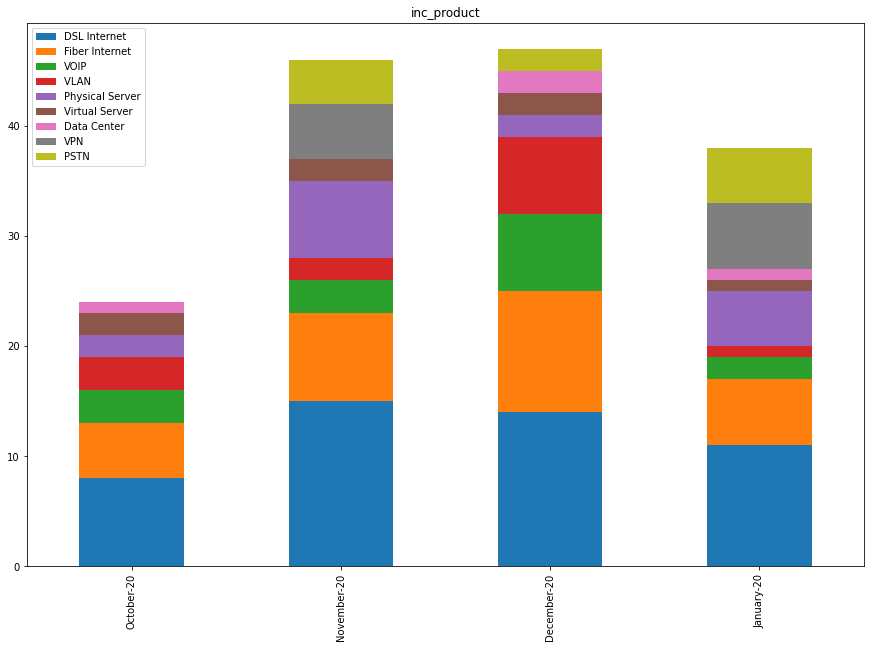

In [23]:
bar_chart('inc_product')

## Task_2 - Mean Time to Resolve (MTTR) 
In order to find the MTTR which is Mean time taken from the creation of the incident (measured) to resolution, first we need to filter our dataset with incidents having measured_flag = 0. I used the Measurable_reason dataset to check the value of incident's measured_flag. 

Then I can found the Resolution Time by applying below formula.
##### `Resolution Time = Incident_Resolution_Time - Incident_Creation_Time`



In [24]:
fact_data[["inc_closure_reason"]].describe()

,inc_closure_reason
count,150
unique,11
top,Dropped & Recovered
freq,41


In [25]:
measurable_reason_data[["inc_closure_reason"]].describe()

,inc_closure_reason
count,11
unique,11
top,Power Supply Back
freq,1


In [26]:
dict_reason = {}
for i in range(len(measurable_reason_data)):
    if measurable_reason_data["inc_closure_reason"][i] not in dict_reason:
        dict_reason[measurable_reason_data["inc_closure_reason"][i]] = measurable_reason_data["measure_flag"][i]
dict_reason

{'Interface Config Change': 1,
 'Dropped & Recovered': 1,
 'No Trouble Found': 0,
 'Ticket Cancelled': 0,
 'Host Config Change': 1,
 'Circuit Config Change': 1,
 'Switch Incident Closed': 1,
 'Server Incident Closed': 1,
 'Power Supply Back': 1,
 'Switch Config Change': 1,
 'Router Config Change': 1}

In [27]:
fact_data["inc_closure_reason_flag"] = "Nan"
for i in range(len(fact_data)):
    if fact_data["inc_closure_reason"][i] in dict_reason:
        fact_data["inc_closure_reason_flag"][i] = dict_reason[fact_data["inc_closure_reason"][i]]
fact_data

<ipython-input-27-56004ae1b826>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["inc_closure_reason_flag"][i] = dict_reason[fact_data["inc_closure_reason"][i]]


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001,1,1
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001,1,Nan
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001,1,Nan
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001,1,Nan


##### Filtering out the incidents which measured_flag value is 0

In [28]:
fact_data_measured = fact_data[fact_data['inc_closure_reason_flag'] == 1].reset_index()
fact_data_measured

,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1


#### Some of values of "inc_resolution_dt" NULL as the compnay is still working on that incident. I deleted those rows as per the below code.

In [29]:
fact_data_measured.dropna(subset = ["inc_resolution_dt"], inplace=True)
fact_data_measured

,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1


In [30]:
fact_data_measured["Resolution Time in hours"] = "Nan"
for i in range(len(fact_data_measured)):
    difference = fact_data_measured["inc_resolution_dt"][i] - fact_data_measured["inc_creation_dt"][i]
    temp = (difference.seconds + int(str(difference)[0]) * 86400) / 3600
    fact_data_measured["Resolution Time in hours"][i] = float("{:.2f}".format(temp))
fact_data_measured

<ipython-input-30-20f9357d56cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data_measured["Resolution Time in hours"][i] = float("{:.2f}".format(temp))


,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1,14.08
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1,2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1,1.4
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52


inc_cust_name
             Bluth Company  Iron Bank  The Alibi Room  Cloud 9 Superstore  \
October-20            4.37       2.00           56.98                6.42   
November-20          13.00      26.76           21.58               33.47   
December-20           4.08      26.66           13.87                6.23   
January-21            5.32       0.81            1.59                5.53   

             Rose Bud Motel  Dunder Mifflin Paper Company, Inc.  \
October-20             3.79                                1.95   
November-20           10.14                               39.97   
December-20           12.07                                6.69   
January-21             1.98                                6.68   

             Pied Piper Inc  
October-20            25.94  
November-20           44.52  
December-20           33.04  
January-21            12.49  


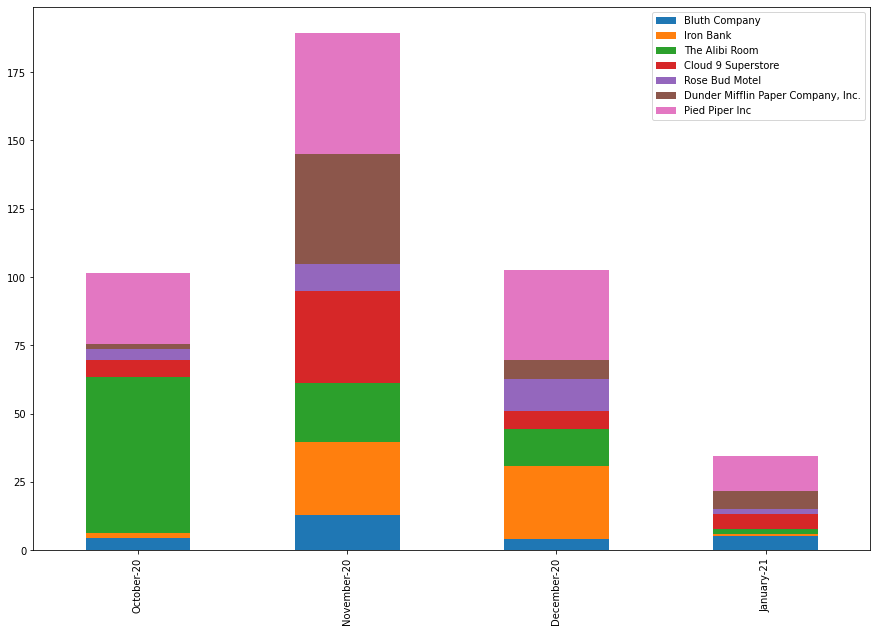

In [31]:
def bar_chart(feature):
    values = fact_data_measured[feature].unique()
    arr = {}
    for i in values:
        for j in fact_data_measured["Month"].unique():
            fact_data_by_month = fact_data_measured[fact_data_measured['Month']== j]
            fact_data_by_month_feature = fact_data_by_month[fact_data_by_month[feature] == i]
            mean_val = float("{:.2f}".format(fact_data_by_month_feature['Resolution Time in hours'].mean()))
            if i not in arr:
                arr[i] = [mean_val]
            else:
                arr[i].append(mean_val)
                
    temp_df = pd.DataFrame(data=arr) 
    temp_df.index = ['October-20','November-20', 'December-20','January-21']
    temp_df.plot(kind='bar',stacked=True, figsize=(15,10))
    print(f"{feature}")
    print(temp_df)
    print("=============================================================================")

#for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
bar_chart('inc_cust_name')


inc_site
             GBC-MH-002  IBB-BRV-001  TAR-SSC-002  C9S-STR-002  IBB-WFL-001  \
October-20         5.07         3.01        50.91        14.08         1.68   
November-20        7.91        52.68        24.09         0.58         0.84   
December-20         NaN         9.98          NaN        25.92        52.55   
January-21          NaN         0.81          NaN         0.14          NaN   

             RBM-SC-001  GBC-CO-001  TAR-SSC-001  DMP-CO-004  C9S-DC-001  ...  \
October-20         3.79        3.67        63.06        1.26        1.13  ...   
November-20        0.58       26.14        20.74         NaN      107.25  ...   
December-20       24.01        1.84        13.87        9.71        2.12  ...   
January-21         1.63        9.26         1.59         NaN       10.92  ...   

             IBB-KLD-001  DMP-CO-001  DMP-CO-002  GBC-DC-001  RBM-SC-004  \
October-20          1.63         NaN         NaN         NaN         NaN   
November-20          NaN       26.61 

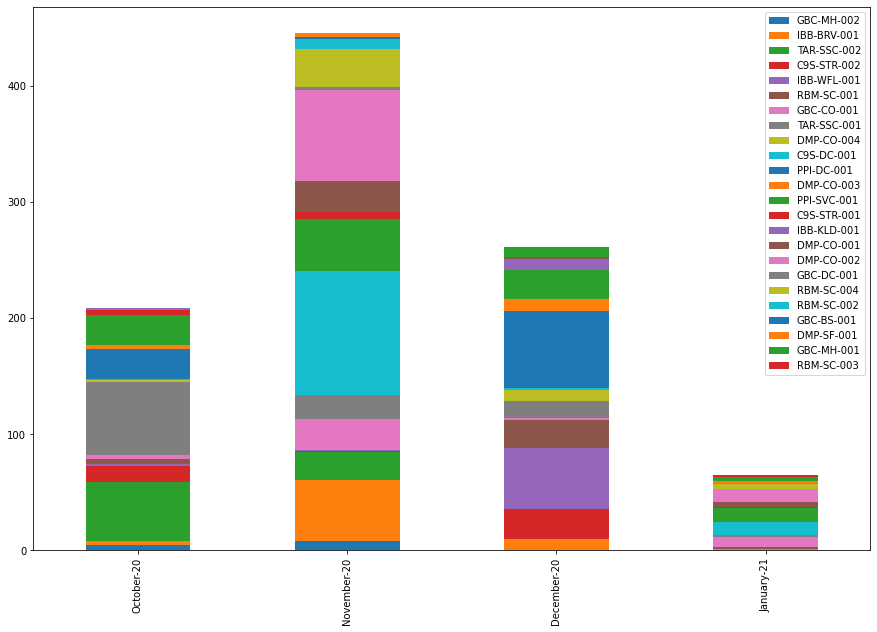

In [32]:
bar_chart('inc_site')

inc_issue_reason
             Interface Down  Switch State Change  Router State Change  \
October-20             3.35                 3.01                50.91   
November-20            6.04                19.07                30.79   
December-20            9.11                 7.64                  NaN   
January-21             0.46                 3.51                17.14   

             Host Down  Circuit Down  Switch Down  Circuit State Change  \
October-20        8.16          3.34         2.42                 33.20   
November-20       5.43          1.02         1.65                 57.67   
December-20       5.19         26.02         1.32                 14.84   
January-21        0.74          1.57         0.63                   NaN   

             Server Down  Power Supply Fail  Cold Start  \
October-20          1.13              25.89       25.98   
November-20        16.08              58.50      135.54   
December-20         2.12              25.74       36.39   
Janua

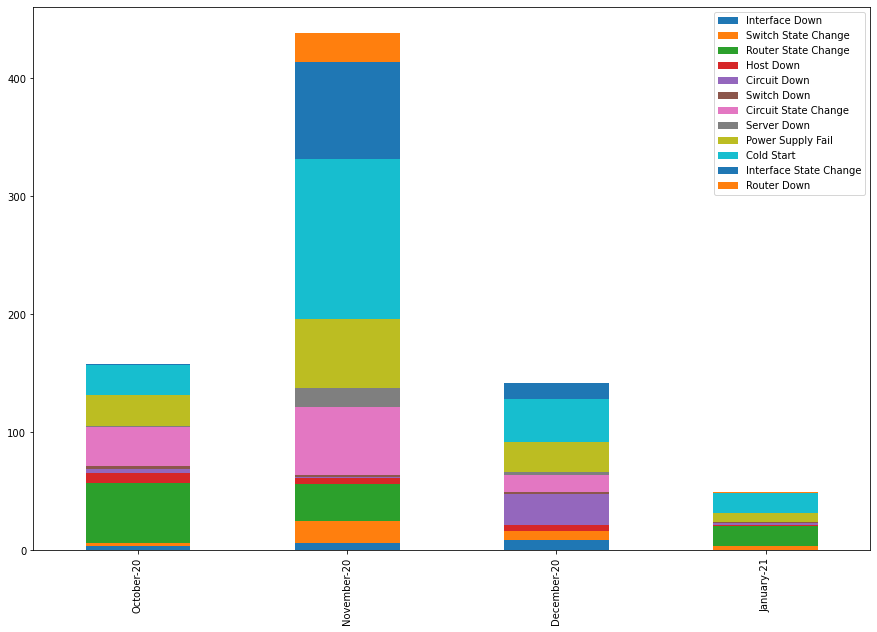

In [33]:
bar_chart('inc_issue_reason')

inc_product
             DSL Internet  VLAN   Fiber Internet   VOIP  Data Center  \
October-20          25.01   2.89           10.85   2.42         1.13   
November-20         19.24   4.17           16.24  53.11          NaN   
December-20          7.13  17.67           28.94   7.87         2.12   
January-21           1.74  24.65            0.31   6.12        30.43   

             Physical Server   PSTN  Virtual Server    VPN  
October-20             25.89    NaN             NaN    NaN  
November-20            93.95  20.58           29.37  32.18  
December-20            66.25  11.46             NaN    NaN  
January-21              0.94   0.86            0.51  11.05  


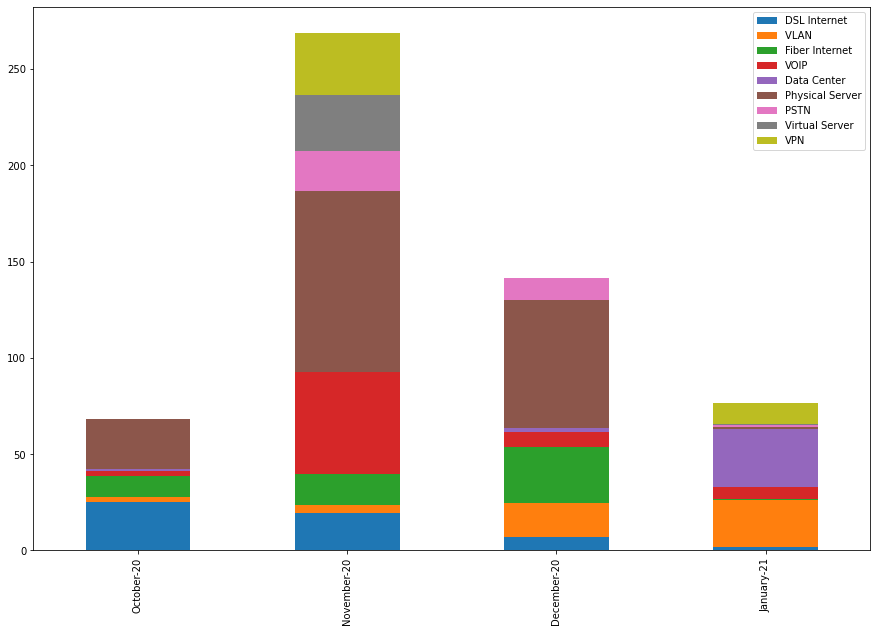

In [34]:
bar_chart('inc_product')

## Task_3 - Mean Time to Resolve % (MTTR %) - 
For Task_3 I need to find the Number of incidents(measured) resolved within the target. I am already having the "Resolution in hour" column and the data is already filtered out with measured_flag. I just need to compare it with the Serverity_Target dataset and check if the particular incident is resolved within the target time. 

##### `MTTR % = (Number of Incidents resolved in time / Total Number of Incidents) * 100`

I added a column "Resolution_in_target_time" with values,

True if Incident was resolved in target time

False if Incident was not resolved in target time

In [35]:
fact_data_measured["Resolution_in_target_time"] = "Nan"
for i in range(len(fact_data_measured)):
    for (j,k) in zip(range(len(Target_data["Severity"])), range(len(Target_data["Target Time To Resolve"]))):
        if fact_data["inc_severity"][i] == Target_data["Severity"][j]:  
            if fact_data_measured["Resolution Time in hours"][i] > Target_data["Target Time To Resolve"][k]:
                fact_data_measured["Resolution_in_target_time"][i] = False
            else:
                fact_data_measured["Resolution_in_target_time"][i] = True  
fact_data_measured

<ipython-input-35-e4395c05299f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data_measured["Resolution_in_target_time"][i] = False
<ipython-input-35-e4395c05299f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data_measured["Resolution_in_target_time"][i] = True


,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours,Resolution_in_target_time
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07,False
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01,True
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91,False
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1,14.08,True
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1,2.18,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1,1.4,True
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81,False
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68,True
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52,True


        Bluth Company  Iron Bank  The Alibi Room  Cloud 9 Superstore  \
Oct_20       0.000000      100.0             0.0          100.000000   
Nov_20      80.000000       75.0            50.0           71.428571   
Dec_20      60.000000       60.0            75.0           60.000000   
Jan_21      66.666667      100.0           100.0           83.333333   

        Rose Bud Motel  Dunder Mifflin Paper Company, Inc.  Pied Piper Inc  
Oct_20             0.0                           66.666667             0.0  
Nov_20            60.0                           25.000000            50.0  
Dec_20            50.0                           50.000000            30.0  
Jan_21           100.0                           85.714286            50.0  


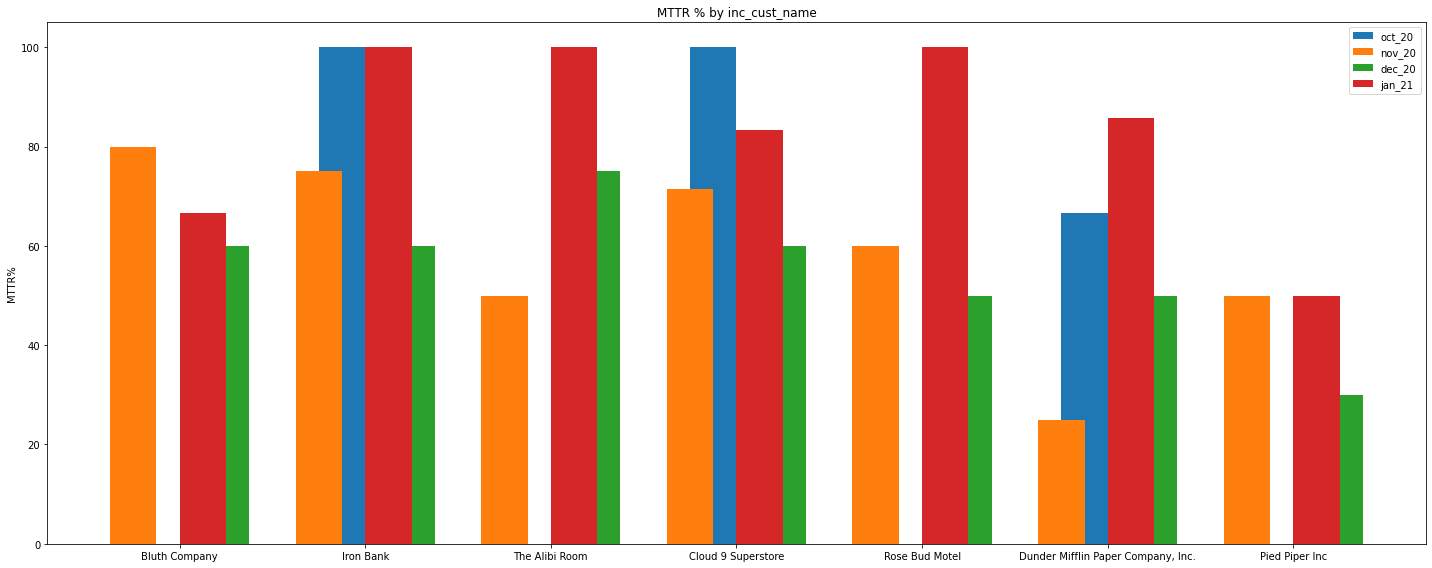

In [36]:
def bar_chart(feature):
    oct_20 = []
    nov_20 = []
    dec_20 = []
    jan_21 = []
    
    labels = fact_data_measured[feature].unique()
    for i in labels:
        for j in fact_data_measured["Month"].unique():
            fact_data_by_month = fact_data_measured[fact_data_measured['Month']== j]
            fact_data_by_month_feature = fact_data_by_month[fact_data_by_month[feature] == i]
            try:
                mttr = fact_data_by_month_feature["Resolution_in_target_time"].value_counts()[True] / fact_data_by_month_feature["Resolution_in_target_time"].count() * 100
            except:
                mttr = 0 
            if j == 10:
                oct_20.append(mttr)
            elif j == 11:
                nov_20.append(mttr)
            elif j == 12:
                dec_20.append(mttr)
            elif j == 1:
                jan_21.append(mttr)
    temp_df = pd.DataFrame([oct_20, nov_20, dec_20, jan_21], columns= labels, index = ["Oct_20", "Nov_20", "Dec_20", "Jan_21"])
    print(temp_df)
    x = np.arange(len(labels)) 
    width = 0.25

    fig, ax = plt.subplots(figsize=(20,8))
    rects1 = ax.bar(x - width/2 , oct_20, width, label='oct_20')
    rects2 = ax.bar(x - width, nov_20, width, label='nov_20')
    rects3 = ax.bar(x + width, dec_20, width, label='dec_20')
    rects4 = ax.bar(x + width/2, jan_21, width, label='jan_21')

  # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MTTR%')
    ax.set_title(f'MTTR % by {feature}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

#for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
bar_chart("inc_cust_name")


        GBC-MH-002  IBB-BRV-001  TAR-SSC-002  C9S-STR-002  IBB-WFL-001  \
Oct_20         0.0        100.0            0        100.0        100.0   
Nov_20       100.0         50.0            0        100.0        100.0   
Dec_20         0.0        100.0            0          0.0         50.0   
Jan_21         0.0        100.0            0        100.0          0.0   

        RBM-SC-001  GBC-CO-001  TAR-SSC-001  DMP-CO-004  C9S-DC-001  ...  \
Oct_20         0.0    0.000000     0.000000  100.000000  100.000000  ...   
Nov_20       100.0   50.000000    66.666667    0.000000    0.000000  ...   
Dec_20         0.0   50.000000    75.000000   33.333333   50.000000  ...   
Jan_21       100.0   66.666667   100.000000    0.000000   66.666667  ...   

        IBB-KLD-001  DMP-CO-001  DMP-CO-002  GBC-DC-001  RBM-SC-004  \
Oct_20        100.0    0.000000    0.000000         0.0         0.0   
Nov_20          0.0   33.333333   33.333333       100.0         0.0   
Dec_20         50.0  100.000000    

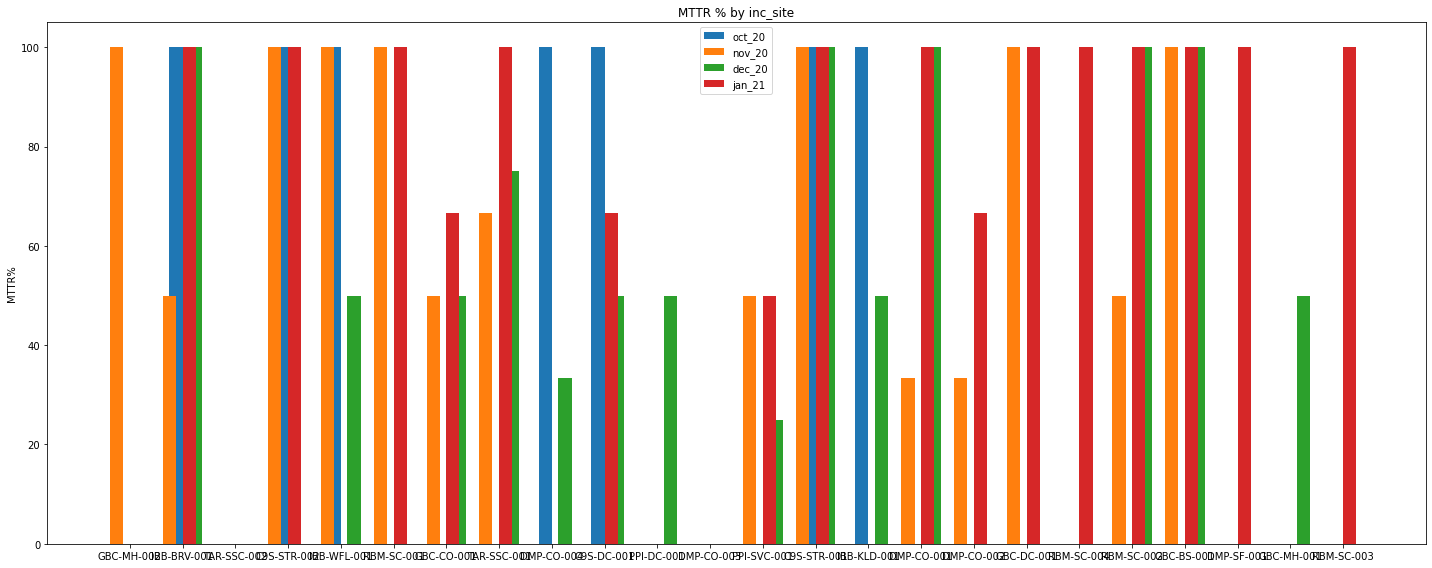

In [37]:
bar_chart("inc_site")

        Interface Down  Switch State Change  Router State Change   Host Down  \
Oct_20            50.0           100.000000             0.000000  100.000000   
Nov_20           100.0            75.000000            33.333333   50.000000   
Dec_20            50.0            66.666667             0.000000   66.666667   
Jan_21           100.0           100.000000            50.000000  100.000000   

        Circuit Down  Switch Down  Circuit State Change  Server Down  \
Oct_20     66.666667    50.000000                   0.0        100.0   
Nov_20     75.000000   100.000000                   0.0         50.0   
Dec_20     60.000000    66.666667                  40.0         50.0   
Jan_21    100.000000   100.000000                   0.0        100.0   

        Power Supply Fail  Cold Start  Interface State Change  Router Down  
Oct_20           0.000000    0.000000                   100.0          0.0  
Nov_20          25.000000    0.000000                     0.0         50.0  
Dec_20 

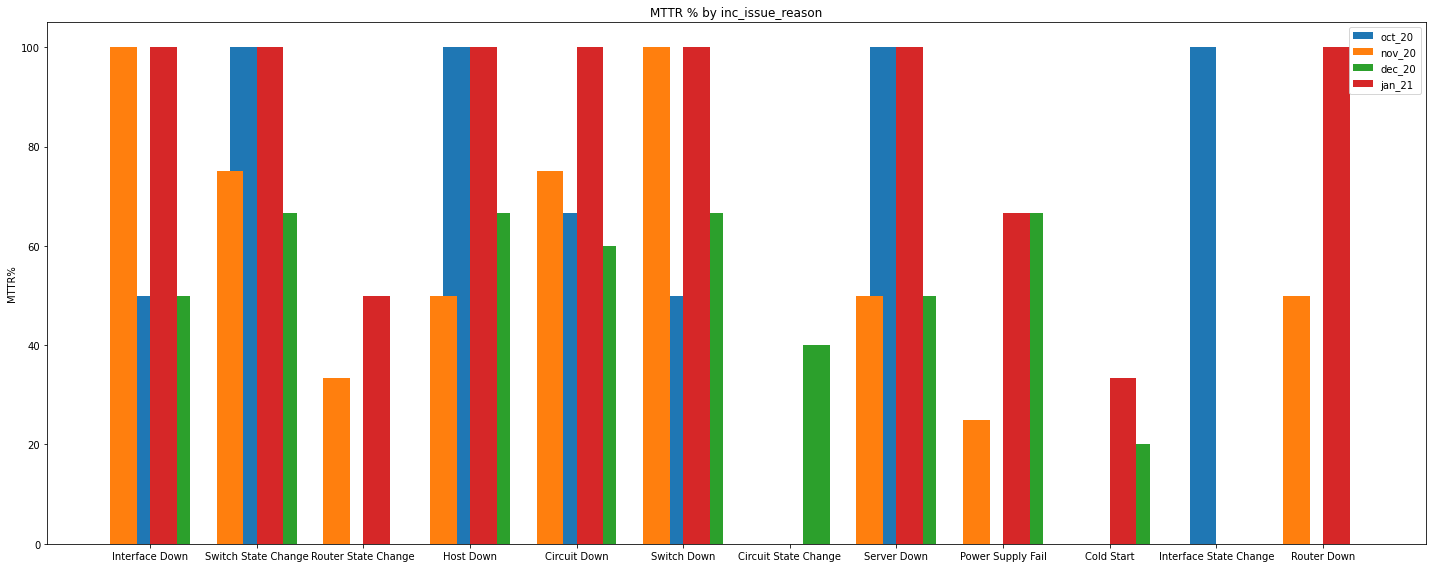

In [38]:
bar_chart("inc_issue_reason")

        DSL Internet       VLAN   Fiber Internet        VOIP  Data Center  \
Oct_20     20.000000  100.000000       75.000000   33.333333        100.0   
Nov_20     66.666667  100.000000       85.714286    0.000000          0.0   
Dec_20     63.636364   42.857143       50.000000   28.571429         50.0   
Jan_21     88.888889    0.000000      100.000000  100.000000          0.0   

        Physical Server        PSTN  Virtual Server        VPN  
Oct_20              0.0    0.000000             0.0   0.000000  
Nov_20             50.0   33.333333             0.0  40.000000  
Dec_20             50.0  100.000000             0.0   0.000000  
Jan_21            100.0  100.000000           100.0  66.666667  


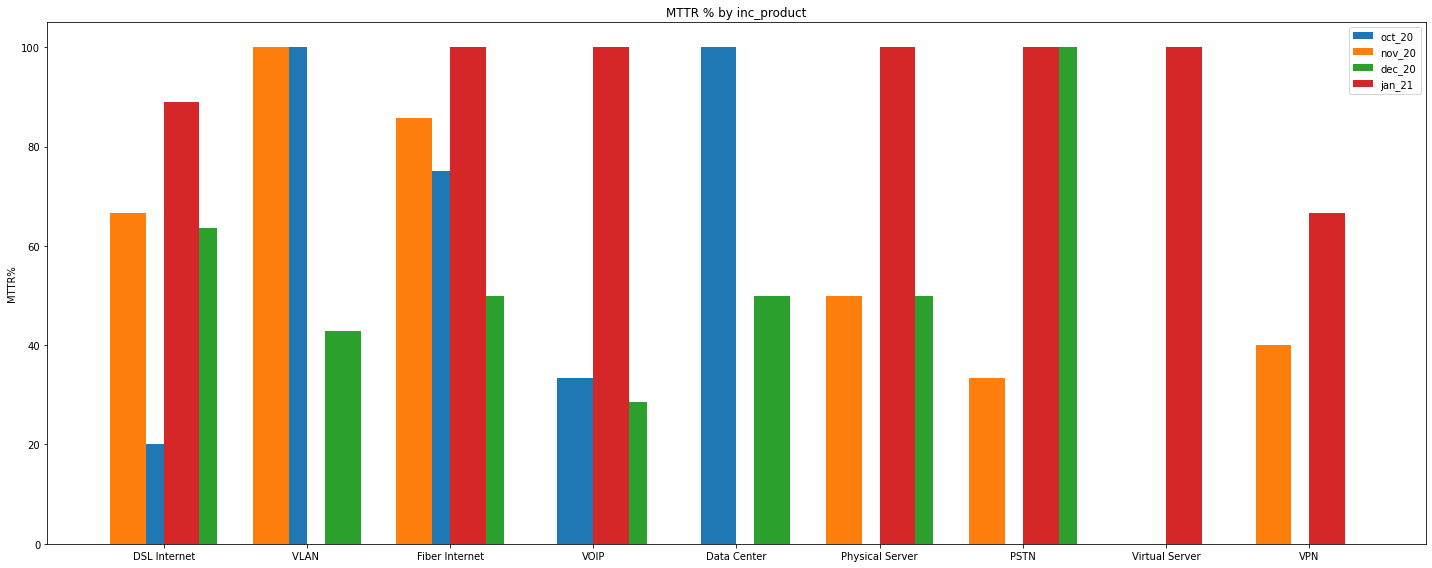

In [39]:
bar_chart("inc_product")

## Task_4 - Service Availability %
In order to get Service Availability per month, we need to first find the Total planned uptime which is the number of hours in a particular month. 
Then we can find the service availability by below formula,

##### `Service Availability % = ((Total planned uptime - Total down time) / Total planned time ) * 100`

In [40]:
fact_data.dropna(subset = ["inc_resolution_dt"], inplace=True)
fact_data
fact_data["Resolution Time in hours"] = "Nan"
for i in range(len(fact_data)):
    difference = fact_data["inc_resolution_dt"][i] - fact_data["inc_creation_dt"][i]
    temp = (difference.seconds + int(str(difference)[0]) * 86400) / 3600
    fact_data["Resolution Time in hours"][i] = float("{:.2f}".format(temp))
fact_data

<ipython-input-40-272b565cbb4d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["Resolution Time in hours"][i] = float("{:.2f}".format(temp))


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0,71.44
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0,71.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,Nan,1.29


         Bluth Company   Iron Bank  The Alibi Room  Pied Piper Inc  \
Oct_20       98.825269   99.330645      100.000000      100.000000   
Nov_20       90.970833   99.768056       99.888889      100.000000   
Dec_20       99.467742   83.424731      100.000000       98.690860   
Jan_21       99.705645  100.000000       99.723118       99.954301   
Average      97.242372   95.630858       99.903002       99.661290   

         Cloud 9 Superstore  Dunder Mifflin Paper Company, Inc.  \
Oct_20            97.412634                           99.698925   
Nov_20            93.612500                           98.863889   
Dec_20            95.811828                           99.331989   
Jan_21            99.893817                           94.974462   
Average           96.682695                           98.217316   

         Rose Bud Motel  
Oct_20        99.490591  
Nov_20        99.737500  
Dec_20        96.756720  
Jan_21        99.716398  
Average       98.925302  


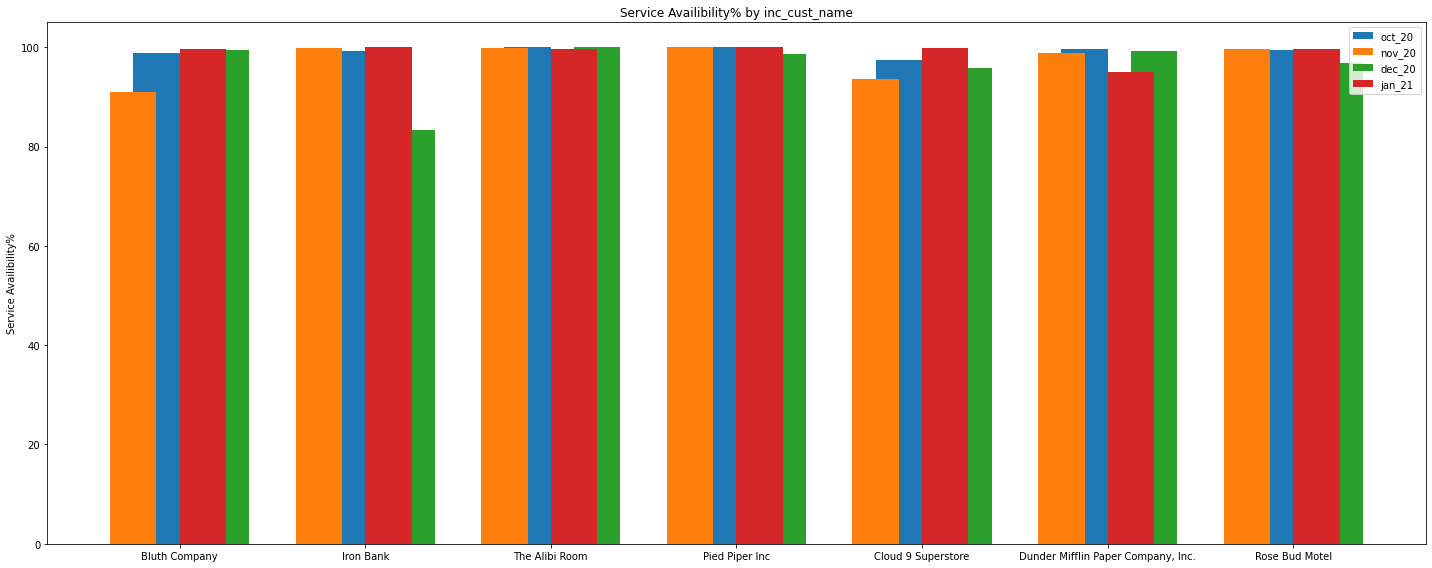

In [41]:
def bar_chart(feature):
    oct_20 = []
    nov_20 = []
    dec_20 = []
    jan_21 = []
    Average = []
    
    month_year = {10:31, 11:30, 12:31, 1:31}
    labels = fact_data[feature].unique()
    
    for i in labels:
        for j in fact_data["Month"].unique():
            fact_data_by_month = fact_data[fact_data['Month']== j]
            fact_data_by_month_feature = fact_data_by_month[fact_data_by_month[feature] == i]
            fact_data_by_month_feature_severity = fact_data_by_month_feature.loc[fact_data_by_month_feature['inc_severity'].isin([1,2])]
            down_time = fact_data_by_month_feature_severity["Resolution Time in hours"].sum()
            uptime = (month_year[j] * 24) - down_time
            service_avail = (uptime / (month_year[j] *24)) * 100
            if j == 10:
                oct_20.append(service_avail)
                service_avail = 0 
            elif j == 11:
                nov_20.append(service_avail)
                service_avail = 0 
            elif j == 12:
                dec_20.append(service_avail)
                service_avail = 0
            elif j == 1:
                jan_21.append(service_avail)
                service_avail = 0
    
    for i in range(len(oct_20)):
        Average.append(statistics.mean([oct_20[i], nov_20[i], dec_20[i], jan_21[i]]))
    
    temp_df = pd.DataFrame([oct_20, nov_20, dec_20, jan_21, Average], columns= labels, index = ["Oct_20", "Nov_20", "Dec_20", "Jan_21", "Average"])
    print(temp_df)

    x = np.arange(len(labels)) 
    width = 0.25

    fig, ax = plt.subplots(figsize=(20,8))
    rects1 = ax.bar(x - width/2 , oct_20, width, label='oct_20')
    rects2 = ax.bar(x - width, nov_20, width, label='nov_20')
    rects3 = ax.bar(x + width, dec_20, width, label='dec_20')
    rects4 = ax.bar(x + width/2, jan_21, width, label='jan_21')


    ax.set_ylabel('Service Availibility%')
    ax.set_title(f'Service Availibility% by {feature}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()
    
bar_chart("inc_cust_name")
    


         GBC-MH-002  IBB-BRV-001  TAR-SSC-002  GBC-DC-001  PPI-DC-001  \
Oct_20    99.318548        100.0        100.0  100.000000       100.0   
Nov_20    98.901389        100.0        100.0   99.612500       100.0   
Dec_20   100.000000        100.0        100.0  100.000000       100.0   
Jan_21   100.000000        100.0        100.0   99.991935       100.0   
Average   99.554984        100.0        100.0   99.901109       100.0   

         C9S-STR-002  IBB-WFL-001  DMP-CO-003  RBM-SC-001  GBC-CO-001  ...  \
Oct_20     98.107527    99.549731       100.0   99.490591   99.506720  ...   
Nov_20     99.838889    99.768056       100.0   99.837500   92.738889  ...   
Dec_20     96.516129    85.873656       100.0   96.772849   99.505376  ...   
Jan_21     99.981183   100.000000       100.0   99.780914   99.733871  ...   
Average    98.610932    96.297861       100.0   98.970464   97.871214  ...   

         PPI-SVC-001  C9S-STR-001  RBM-SC-003  GBC-MH-001  DMP-CO-001  \
Oct_20    100.00000

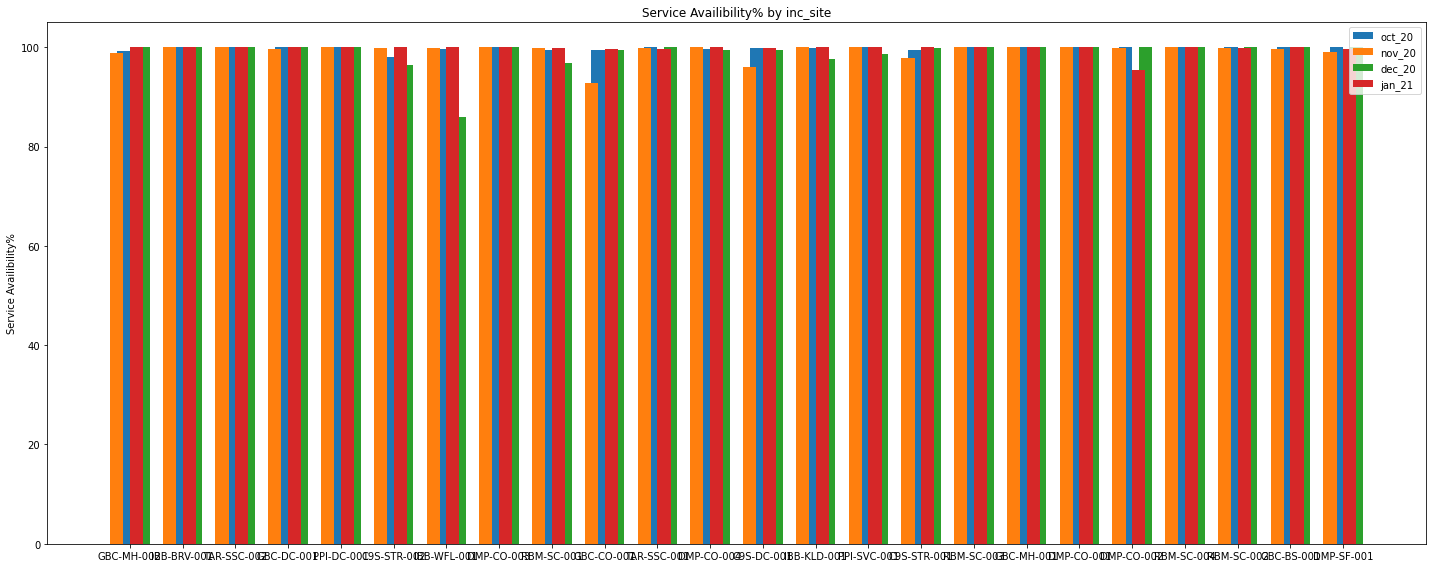

In [42]:
bar_chart("inc_site")

## Task_5 - Additional Information

In [43]:
fact_data["Resolution_in_target_time"] = "Nan"
for i in range(len(fact_data)):
    for (j,k) in zip(range(len(Target_data["Severity"])), range(len(Target_data["Target Time To Resolve"]))):
        if fact_data["inc_severity"][i] == Target_data["Severity"][j]:  
            if fact_data["Resolution Time in hours"][i] > Target_data["Target Time To Resolve"][k]:
                fact_data["Resolution_in_target_time"][i] = False
            else:
                fact_data["Resolution_in_target_time"][i] = True  
fact_data

<ipython-input-43-c436b6bf7c04>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["Resolution_in_target_time"][i] = False
<ipython-input-43-c436b6bf7c04>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_data["Resolution_in_target_time"][i] = True


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours,Resolution_in_target_time
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07,False
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01,True
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91,False
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0,71.44,False
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0,71.52,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81,True
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68,True
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52,True
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,Nan,1.29,True


In [44]:
df_fact = fact_data[['inc_creation_dt', 'inc_resolution_dt', 'inc_issue_reason', 'inc_closure_reason', 'inc_cust_name', 'inc_product','Month', 'inc_closure_reason_flag',	'Resolution Time in hours',	'Resolution_in_target_time'  ]]
df_fact


,inc_creation_dt,inc_resolution_dt,inc_issue_reason,inc_closure_reason,inc_cust_name,inc_product,Month,inc_closure_reason_flag,Resolution Time in hours,Resolution_in_target_time
0,2020-10-02 02:54:15,2020-10-02 07:58:31,Interface Down,Interface Config Change,Bluth Company,DSL Internet,10,1,5.07,False
1,2020-10-02 07:15:21,2020-10-02 10:15:47,Switch State Change,Dropped & Recovered,Iron Bank,VLAN,10,1,3.01,True
2,2020-10-02 09:44:23,2020-10-04 12:39:10,Router State Change,Dropped & Recovered,The Alibi Room,DSL Internet,10,1,50.91,False
3,2020-10-05 11:24:29,2020-10-08 10:50:40,Power Supply Fail,No Trouble Found,Bluth Company,Physical Server,10,0,71.44,False
4,2020-10-05 11:24:29,2020-10-08 10:55:40,Cold Start,Ticket Cancelled,Pied Piper Inc,Virtual Server,10,0,71.52,False
...,...,...,...,...,...,...,...,...,...,...
146,2021-01-26 01:21:08,2021-01-27 03:09:33,Cold Start,Dropped & Recovered,Bluth Company,VPN,1,1,25.81,True
147,2021-01-26 04:30:59,2021-01-26 06:12:03,Switch State Change,Dropped & Recovered,Rose Bud Motel,DSL Internet,1,1,1.68,True
148,2021-01-27 01:58:40,2021-01-27 02:29:41,Power Supply Fail,Power Supply Back,"Dunder Mifflin Paper Company, Inc.",VPN,1,1,0.52,True
149,2021-01-27 08:55:54,2021-01-27 10:13:07,Interface Down,NaN,The Alibi Room,PSTN,1,Nan,1.29,True


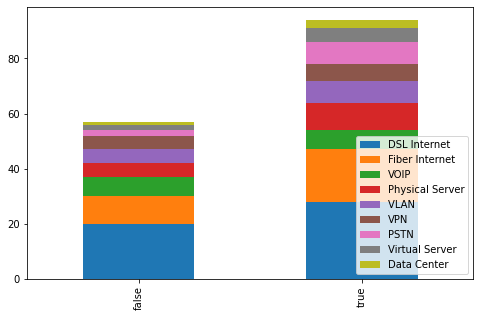

In [45]:
def bar_chart(feature):

    false = df_fact[df_fact['Resolution_in_target_time']== False][feature].value_counts()
    true = df_fact[df_fact['Resolution_in_target_time']== True][feature].value_counts()
    temp = pd.DataFrame([false,true])
    temp.index = ['false','true']
    temp.plot(kind='bar',stacked=True, figsize=(8,5))

#for i in df_fact[['inc_product', 'inc_cust_name', 'inc_issue_reason', 'inc_closure_reason', 'inc_closure_reason_flag', 'Month']]:
bar_chart('inc_product')


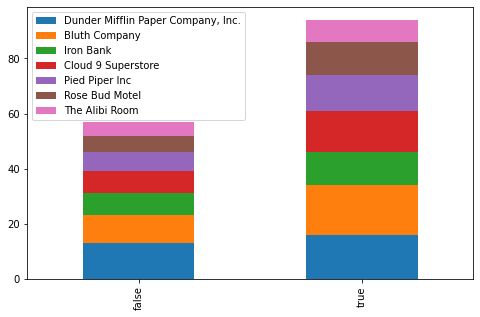

In [46]:
bar_chart('inc_cust_name')

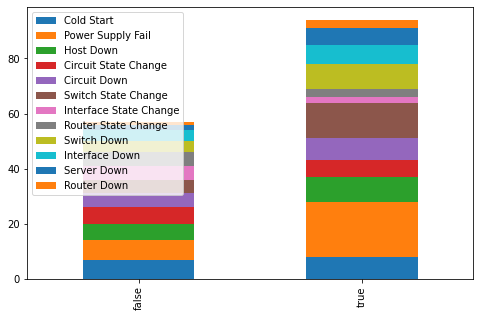

In [47]:
bar_chart('inc_issue_reason')

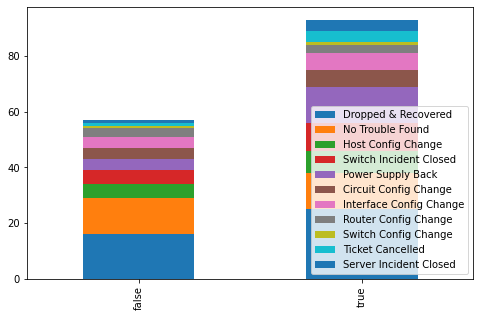

In [48]:
bar_chart('inc_closure_reason')

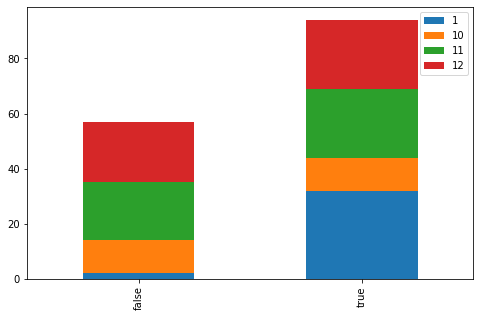

In [49]:
bar_chart('Month')